In [162]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_validate,GridSearchCV, RandomizedSearchCV,learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.pipeline import Pipeline
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from bert_serving.client import BertClient
import requests

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Goal: identifying patients with Cardiovascular Disease who are at higher risk AND recommend any effective interventions to mitigate the risk. 
## One of the main obstacles for data scientist in the clinical domain is patients EHR data access, so I planned to use the data from [Kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) and [Clinical NLP Workshop 2020](https://clinical-nlp.github.io/2020/resources.html) to demo our analysis idea and processing workflow in this notebook.  
# Purpose: But due to time limitation and computing resoures at hand, I choose two small and simple datasets to go through the proposed data analysis workflow. So, no meaningful facts or knowledge discovered after this notebook, it's more of an idea demo.
### 1. Demo how to create traditional machine learning classification models to find positive samples(CVD-patients) with structured CVD patients data (structured demo data like: lab values and medications from Kaggle);  
### 2. Demo how to process EHR text data with NLP algorithms(BERT-based,) to generate structured embeddings to represent patients as vectors and integrate with above structured data for training models. (unstructured demo data from task-email and MIMIC (TBD))
### 3. Find significant risk factors and meaningful features to support above model training with more data from both molecular level and real word evidence; (High Blood Pressure, High Blood Cholesterol, Obesity, Smoking, Physical Inactivity, etc.). Some risk factors may be controlled or eliminated to reduce the risk of heart disease, those hiden information can also be minned with NLP and statistics from RWD.

## 1. Classification model demo (using Labeled cadiovascular diseases dataset):
The dataset consists of 70 000 records of patients data in 12 features, such as some risk factors:  
- age
- gender
- systolic blood pressure
- diastolic blood pressure
- if smoking
- alcohol intake  
The target class "cardio" equals to 1, when patient has cardiovascular desease, and it's 0, if patient is healthy.

In [140]:
df = pd.read_csv(r"./data/cardio_01_kaggle.csv", sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### 1.1 Data EDA

In [141]:
# quick review columns
df = df.drop(['id'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [142]:
# auto-EDA by pd-Profiling, may help us to find significant risk factors and feature correlations quickly
profile = ProfileReport(df, title="EDA-Report", explorative=True)
profile.to_widgets()


In [143]:
# Basic stats for numeric column
df_desc = df.describe().drop(columns=['gender','cholesterol','gluc','smoke','alco','active','cardio'])
df_desc

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


In [144]:
# if data sample is balanced based on target type
print(df['cardio'].value_counts())

#add a figure
fig = go.Figure([go.Pie(labels=['No-CVD', 'CVD'],values=df['cardio'].value_counts().values)])
fig.update_layout(title_text="If sample is balanced?", template="plotly_white")
fig.data[0].marker.line.color = 'rgb(255, 255, 255)'
fig.data[0].marker.line.width = 2
fig.update_traces(hole=.4,)
fig.show()

0    35021
1    34979
Name: cardio, dtype: int64


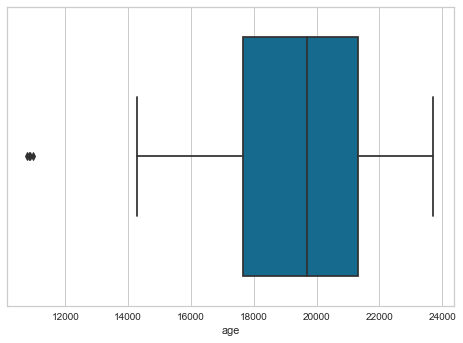

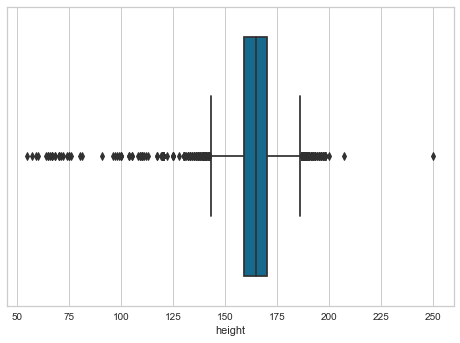

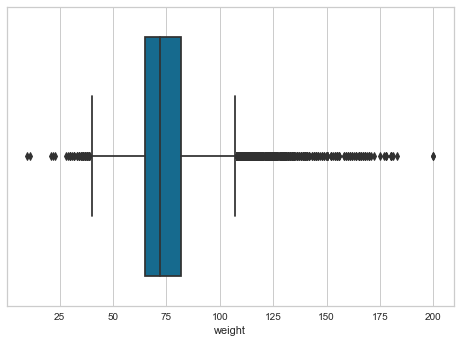

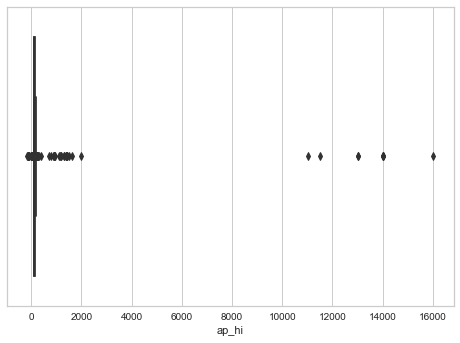

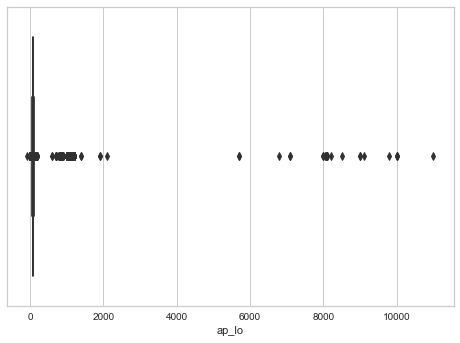

In [145]:
# Visualize if any obvious outliers for numeric features, and remove them
quanti_columns = df.drop(['gender', 'cholesterol','gluc', 'smoke', 'alco', 'active', 'cardio'], axis=1)
for col in quanti_columns:
    plt.figure()
    sns.boxplot(df[col])

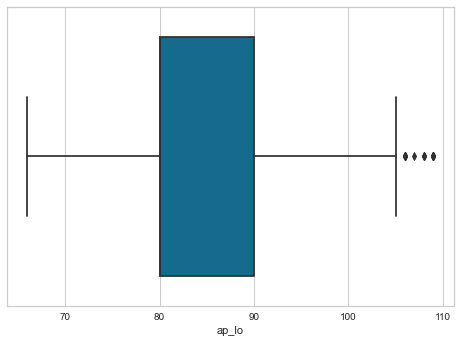

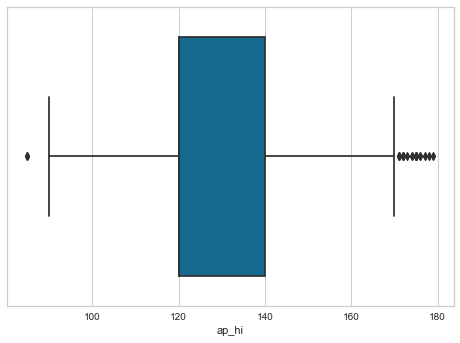

In [146]:
# drop obvious ouliers in "Systolic blood pressure" and "Diastolic blood pressure"
df = df.query("ap_lo<110 & ap_lo>65 & ap_hi<180 & ap_hi>80")
for col in ['ap_lo','ap_hi']:
    plt.figure()
    sns.boxplot(df[col])

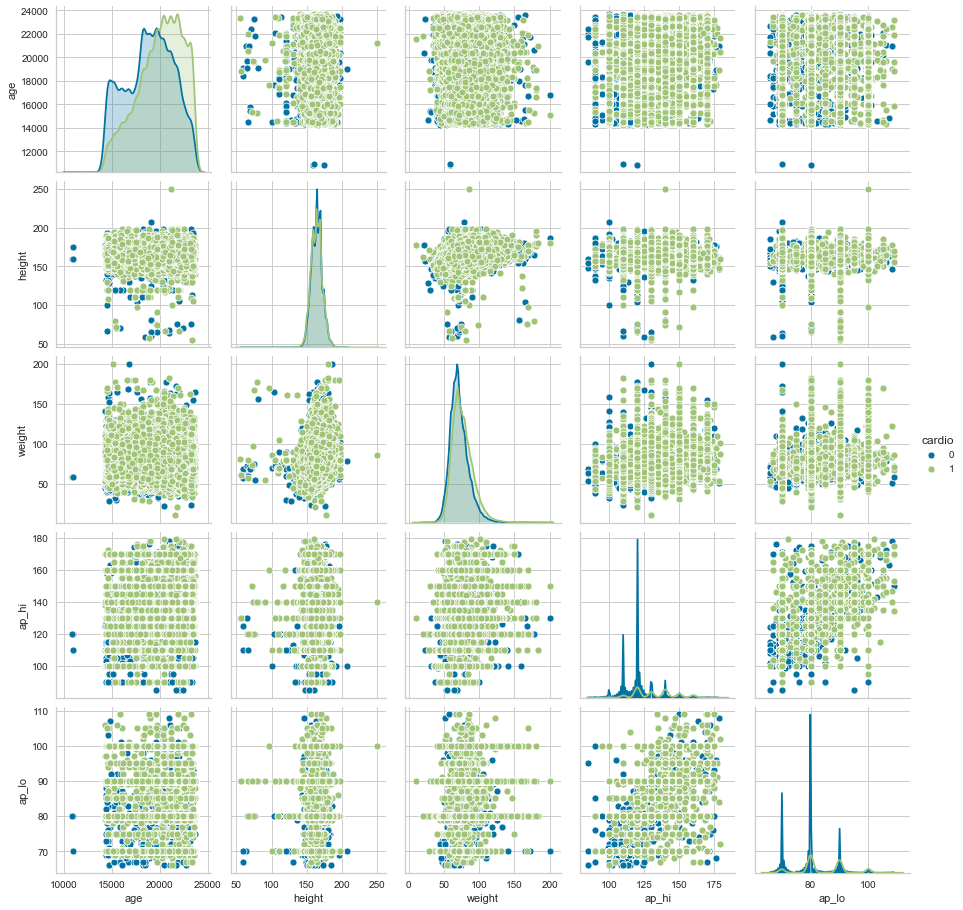

In [147]:
# pairwise-plot to show relationship between any two features and data distribution on single feature
sns.pairplot(df, 
             hue='cardio',
             vars=df_desc.columns,
             )
plt.show()


### 1.2 Training a classification model

#### 1.2.1 Data split and feature normalization

In [148]:
# Divide dataset Train set & Test set
X = df.drop("cardio", axis=1)
y = df["cardio"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2, random_state=0)

In [149]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### 1.2.2 Feature selection/evaluation

In [150]:
feature_eva = chi2(X, y)
feature_eva = pd.DataFrame(columns=X.columns,
                           data=feature_eva, 
                           index=["Chi2 Score", "P-value"]).transpose().sort_values("Chi2 Score", ascending=False)
feature_eva

,Chi2 Score,P-value
age,1.080908e+06,0.000000e+00
ap_hi,1.968309e+04,0.000000e+00
ap_lo,5.332087e+03,0.000000e+00
weight,4.732881e+03,0.000000e+00
cholesterol,1.053039e+03,5.319512e-231
gluc,1.278109e+02,1.234633e-29
smoke,2.179061e+01,3.040854e-06
active,1.717876e+01,3.402184e-05
height,1.019850e+01,1.405551e-03
alco,7.155787e+00,7.472249e-03


#### 1.2.3 Model training and evaluation

In [151]:
seed = 123

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))

results = []
names = []
# scorer = 'accuracy' #using accuracy for quick-demo
scorer = 'f1' #using recall for imbalanced dataset

for name, model in models:
#     print(name)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, 
                                                 X, 
                                                 y, 
                                                 cv=kfold, 
                                                 scoring=scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Avg_%f (std_%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



LR: Avg_0.683818 (std_0.005131)
LDA: Avg_0.699755 (std_0.004194)
KNN: Avg_0.667430 (std_0.005390)
CART: Avg_0.625889 (std_0.006827)
NB: Avg_0.680065 (std_0.002833)
SVM: Avg_0.576114 (std_0.005737)
RF: Avg_0.702630 (std_0.008291)
AdaBoost: Avg_0.702602 (std_0.003155)


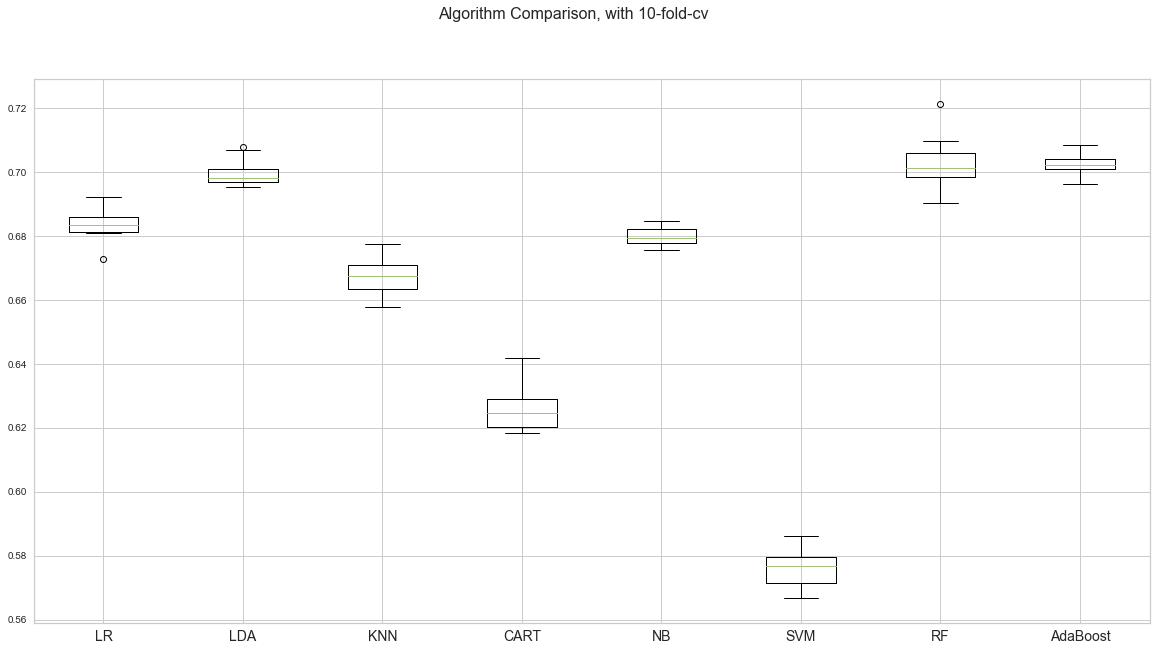

In [152]:
# algorithm comparision
fig = plt.figure(figsize=(20,10))

fig.suptitle('Algorithm Comparison, with 10-fold-cv', fontsize=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, fontdict={'fontsize':14})
plt.show()

In [ ]:
# Model hyper-parameters Optimization with GridSearch for a selected algorithm
# AdaBoostClassifier()

param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
              'base_estimator__splitter' :   ['best', 'random'],
              'n_estimators': [50, 100, 200,300],
              'learning_rate' : [0.5, 1.0, 1.5],
             }

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
grid_search_ada = GridSearchCV(ada, param_grid=param_grid, cv=5)
grid_search_ada.fit(X, y)

In [ ]:
#Model evaluation with AUC ROC score
from sklearn.metrics import roc_auc_score, roc_curve

logit_roc_auc = roc_auc_score(y_test, grid_search_ada.best_estimator_.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, grid_search_ada.best_estimator_.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 2. EHR text data processing to enhance above binary model accuracy and provide more insights (just an idea proposal demo)
Using text data from Electronic Health Records to predict events and onset of diseases.

In [104]:
import pandas as pd
import scispacy
import spacy

# nlp = spacy.load("en_core_sci_sm")
nlp = spacy.load("en_ner_bionlp13cg_md") #using a biomed model here, train a customized model for EHR in future

In [105]:
df_ehr = pd.read_csv(r'./data/cardio_02_holmusk.csv')
# df.reset_index(inplace=True)
df_ehr.head()

,Notes,Description
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...


### 2.1 BioMedical NER/Concept extraction to find any interesting/common factors from EHR Notes

In [106]:
def add_ner(text, model):
    doc = model(text)
    ent_ls = []
    for ent in doc.ents:
        ent_dict = {'ner': ent.text,
                   'ner_type': ent.label_}
        ent_ls.append(ent_dict)

    df_ent = pd.DataFrame(ent_ls)
    df_ent = df_ent.groupby(['ner','ner_type']).size().reset_index(name='count')
    
    return df_ent

ner_ls = []
for index, row in df_ehr.iterrows():
    text = row['Notes'] + row['Description']
    ner = add_ner(text,nlp)
    ner['patient_id'] = index
    ner_ls.append(ner)
df_ner = pd.concat(ner_ls, ignore_index=True)
df_ner = df_ner[~df_ner['ner'].isin(['patient','heart','wall','left'])]

In [107]:
# biomedical NER type we used here:
df_ner['ner_type'].unique()
# df_ner['ner'].value_counts()

array(['MULTI-TISSUE_STRUCTURE', 'GENE_OR_GENE_PRODUCT',
       'PATHOLOGICAL_FORMATION', 'TISSUE', 'ORGAN', 'SIMPLE_CHEMICAL',
       'CELL', 'ORGANISM', 'CANCER', 'ORGANISM_SUBDIVISION',
       'IMMATERIAL_ANATOMICAL_ENTITY', 'ORGANISM_SUBSTANCE',
       'CELLULAR_COMPONENT'], dtype=object)

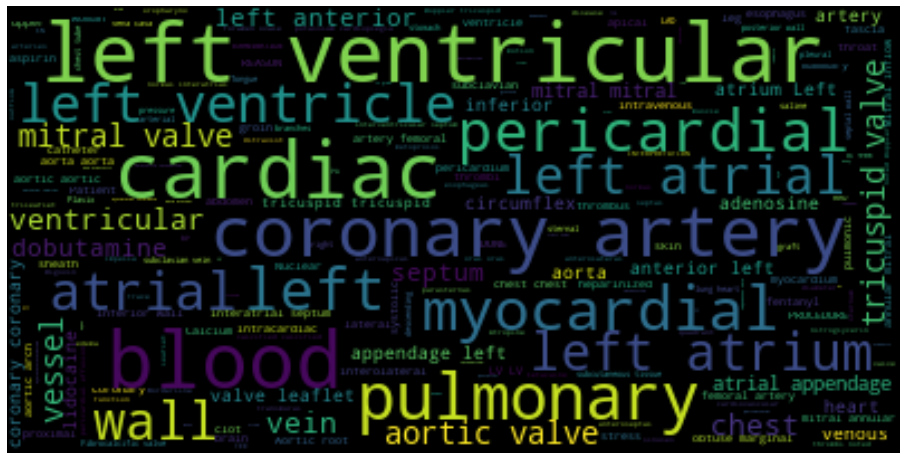

In [108]:
# Generate a word-cloud to see frequent NERs
ner_txt = df_ner['ner'].str.cat(sep='\n')
wordcloud = WordCloud(background_color="black",
                     min_font_size=2).generate(ner_txt)
plt.figure(figsize = (16, 9))
plt.imshow(wordcloud, 
           interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.2 Patient EHR notes to vectors, make text to structured embeddings for further Machine Learning use.
Different strategy and methods to use pre-trained models can for text-to-vectors here, such as: [Scispacy](https://allenai.github.io/scispacy/)/[Blue-BERT](https://arxiv.org/pdf/1906.05474.pdf)/[Clinical-BERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) /[BERT-as-service](https://github.com/hanxiao/bert-as-service) etc.

#### 2.2.1 Using pre-trained biomedical word2vec models in scispacy for EHR notes embedding to represent patients

In [163]:
bc = BertClient()

# Launch the bert-service server to host BERT models by running below cmd:
#!bert-serving-start -model_dir ./pre_trained_models/BlueBert/ -num_worker=4

def vect_spacy(text):
    return nlp(text).vector

def vect_bert(text):
    return bc.encode([text])
    
# Sentence embedding by word2vec models(pre-trained with biomedical text by scispacy)
df_ehr_emb = df_ehr.copy()
df_ehr_emb['vect_spacy'] = (df_ehr_emb['Notes'] + df_ehr_emb['Description']).apply(vect_spacy)

# Sentence embedding by BlueBERT
df_ehr_emb['vect_bert'] = (df_ehr_emb['Notes'] + df_ehr_emb['Description']).apply(vect_bert)


In [165]:
# patients EHR notes after embedded
df_ehr_emb.head()

,Notes,Description,vect_spacy,vect_bert
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,"[-0.004973088, 0.0914922, -0.013571998, -0.031...","[[-0.518397, -0.33278176, 0.5525791, -0.485670..."
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,"[0.000469358, 0.07411429, 0.015031684, -0.0349...","[[-0.4708939, 0.31249622, 0.53501505, -0.40054..."
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram,"[0.015388086, 0.08677035, 0.0067353146, -0.051...","[[-0.25075305, -0.14786515, 0.27276453, -0.337..."
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler,"[-0.01238479, 0.07874539, -0.00156944, -0.0076...","[[-0.5499993, -0.13692743, 0.34801665, -0.2794..."
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...,"[-0.024865359, 0.015693076, 0.05676712, -0.017...","[[-0.32680768, -0.023793474, 0.16002119, -0.74..."


In [ ]:
# choosing spacy embeddings for further analysis demo
vect_sp = np.array(df_ehr_emb['vect_spacy'].values.tolist())
sim_w2v = cosine_similarity(vect_sp)

<AxesSubplot:>

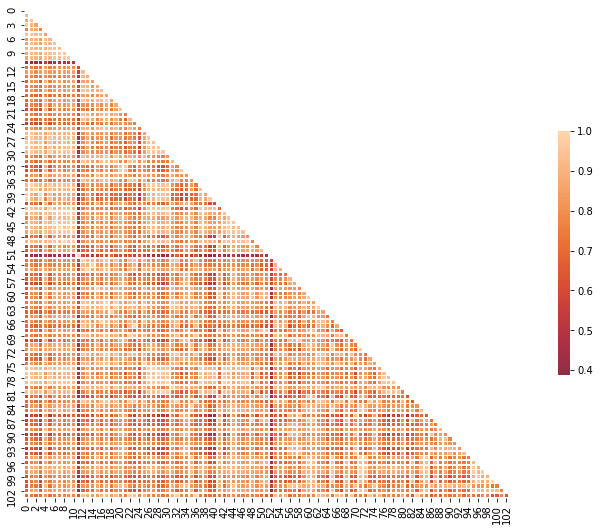

In [112]:
# Measuring pairwise patients similarity(based on EHR)
mask = np.triu(np.ones_like(sim_w2v, dtype=bool))
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(sim_w2v, mask=mask, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2.3 Patient Clustering

In [113]:
df_ehr_emb

,Notes,Description,vect_spacy
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,"[-0.004973088, 0.0914922, -0.013571998, -0.031..."
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,"[0.000469358, 0.07411429, 0.015031684, -0.0349..."
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram,"[0.015388086, 0.08677035, 0.0067353146, -0.051..."
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler,"[-0.01238479, 0.07874539, -0.00156944, -0.0076..."
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...,"[-0.024865359, 0.015693076, 0.05676712, -0.017..."
...,...,...,...
99,"TITLE OF PROCEDURE: ,Coronary artery bypass g...",Coronary artery bypass grafting times three u...,"[0.04321123, 0.02464008, 0.049424157, -0.01556..."
100,"PREOPERATIVE DIAGNOSIS: , Coronary occlusive d...",Coronary bypass graft x2 utilizing left inter...,"[0.04237677, 0.02259597, 0.054984145, -0.01189..."
101,"SUBJECTIVE: , The patient states that she feel...",Atrial fibrillation with rapid ventricular re...,"[-0.022352165, 0.013454253, 0.071804315, -0.00..."
102,"DIAGNOSIS: , Aortic valve stenosis with corona...",Aortic valve replacement using a mechanical v...,"[0.03928584, 0.02982386, 0.049911223, -0.02087..."


In [134]:
df_ehr_emb_2 = pd.DataFrame(df_ehr_emb['vect_spacy'].values.tolist(),
                            index=df_ehr_emb['vect_spacy'].index)
df_ehr_emb_2

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.004973,0.091492,-0.013572,-0.031578,0.088375,-0.037390,0.019819,0.115451,-0.062825,-0.067640,...,-0.033034,-0.100995,0.062770,0.101217,0.029610,0.049960,0.041414,0.014854,-0.013875,-0.088272
1,0.000469,0.074114,0.015032,-0.034968,0.104556,-0.045702,0.029827,0.027046,-0.052270,-0.055640,...,-0.014956,-0.072861,0.045683,0.062237,0.034884,0.004288,0.064159,0.074373,0.015877,-0.082308
2,0.015388,0.086770,0.006735,-0.051798,0.116638,-0.041660,0.010946,0.019926,-0.067943,-0.060404,...,-0.040232,-0.042612,0.037500,0.052382,0.027913,-0.004295,0.047437,0.057512,0.013526,-0.117563
3,-0.012385,0.078745,-0.001569,-0.007619,0.103345,-0.028985,0.028384,0.089995,-0.053910,-0.079459,...,-0.041312,-0.061103,0.063808,0.098310,0.028701,0.023910,0.034354,0.012400,-0.004616,-0.053654
4,-0.024865,0.015693,0.056767,-0.017093,0.065132,-0.013490,0.005989,0.002027,-0.045225,0.000314,...,-0.006157,-0.046542,-0.008439,0.069543,0.010178,-0.030502,0.020411,0.097361,-0.004882,-0.091969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.043211,0.024640,0.049424,-0.015562,0.076927,-0.038917,-0.007379,-0.020888,-0.079440,0.000750,...,-0.051344,0.000579,0.011564,0.054591,0.028783,-0.009740,0.025861,0.014419,0.000218,-0.037634
100,0.042377,0.022596,0.054984,-0.011897,0.069634,-0.028372,-0.000553,-0.022771,-0.062054,-0.006150,...,-0.040750,-0.002381,0.011497,0.058644,0.022221,-0.005930,0.027202,0.020278,0.002609,-0.030218
101,-0.022352,0.013454,0.071804,-0.003444,0.037510,0.012349,-0.002109,0.004873,-0.038301,0.015533,...,0.008532,-0.034197,-0.021230,0.085536,-0.012581,-0.004902,0.014194,0.091860,-0.023939,-0.081270
102,0.039286,0.029824,0.049911,-0.020875,0.068063,-0.069005,-0.006155,-0.001245,-0.071043,-0.018712,...,-0.027926,-0.038846,0.038280,0.045851,0.009747,-0.003402,0.065482,0.056991,0.004861,-0.080653


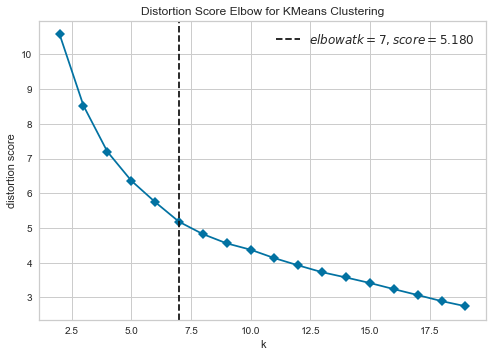

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [135]:
#%% pre-evaluate the best K by Elbow
model = KMeans(random_state=123456)
visualizer = KElbowVisualizer(model, k=(2,20),
                              metric='distortion',
                              timings=False)

visualizer.fit(df_ehr_emb_2)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [136]:
# start clustering
kmeans = KMeans(n_clusters=6,random_state=1233456).fit(df_ehr_emb_2)
df_ehr_emb_2['cluster'] = kmeans.labels_
df_ehr_emb_2['cluster'] = df_ehr_emb_2['cluster'].astype(str)
# Entity embedding using t-SNE for visualization
tsne = TSNE(n_components=3,
           init='pca',
           random_state=1234).fit_transform(df_ehr_emb_2)

df_ehr_emb_2['tsne_1'] = tsne[:,0]
df_ehr_emb_2['tsne_2'] = tsne[:,1]
df_ehr_emb_2['tsne_3'] = tsne[:,2]

In [137]:
df_ehr_emb_2.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,cluster,tsne_1,tsne_2,tsne_3
0,-0.004973,0.091492,-0.013572,-0.031578,0.088375,-0.037390,0.019819,0.115451,-0.062825,-0.067640,...,0.029610,0.049960,0.041414,0.014854,-0.013875,-0.088272,5,-19.953741,-161.841064,-37.420166
1,0.000469,0.074114,0.015032,-0.034968,0.104556,-0.045702,0.029827,0.027046,-0.052270,-0.055640,...,0.034884,0.004288,0.064159,0.074373,0.015877,-0.082308,5,30.393812,-96.823219,14.014612
2,0.015388,0.086770,0.006735,-0.051798,0.116638,-0.041660,0.010946,0.019926,-0.067943,-0.060404,...,0.027913,-0.004295,0.047437,0.057512,0.013526,-0.117563,5,74.457848,-124.114403,33.538292
3,-0.012385,0.078745,-0.001569,-0.007619,0.103345,-0.028985,0.028384,0.089995,-0.053910,-0.079459,...,0.028701,0.023910,0.034354,0.012400,-0.004616,-0.053654,5,-8.417542,-132.032745,13.251493
4,-0.024865,0.015693,0.056767,-0.017093,0.065132,-0.013490,0.005989,0.002027,-0.045225,0.000314,...,0.010178,-0.030502,0.020411,0.097361,-0.004882,-0.091969,2,89.278023,21.681765,51.903454


In [138]:
fig = px.scatter(df_ehr_emb_2, x="tsne_1", y="tsne_2", color="cluster",)
fig.show()

### 2.4 Integrate with above structured data for training more accurate classification models (patients lab values, medications and demographic data etc.)

Sine data we used here are not real world data come from the same patients, just a workflow demo, the real integration and further analysis and modeling are going to explore in the future.